# Bayesian parameter sampling with a SMIRFF forcefield

This notebook will generate very simple reference data by doing single-point energy evaluations for a large number of compounds. It will then use this reference data, combined with an estimate of the uncertainties in these energies, to do Bayesian sampling of parameter space to determine the distributions of one or more parameters that are consistant with the reference energies. 

### Do imports

In [1]:
# Imports needed
%matplotlib inline
from smarty import ForceField
from smarty import *
import openeye
from openeye import oechem
from openeye import oeomega
from openeye import oequacpac
import smarty
from simtk import openmm
from simtk.openmm import app
from simtk import unit
import numpy as np
from smarty.utils import get_data_filename
import random
import matplotlib
import pylab as pl
import os

### Prep utility functions

In [2]:
# Define utility function we'll use to get energy of an OpenMM system
def get_energy(system, positions):
    """
    Return the potential energy.

    Parameters
    ----------
    system : simtk.openmm.System
        The system to check
    positions : simtk.unit.Quantity of dimension (natoms,3) with units of length
        The positions to use
    Returns
    ---------
    energy (kcal/mol)
    """

    integrator = openmm.VerletIntegrator(1.0 * unit.femtoseconds)
    context = openmm.Context(system, integrator)
    context.setPositions(positions)
    state = context.getState(getEnergy=True)
    energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
    return energy

def get_minimum_energy(system, topology, positions):
    """
    Return the potential energy after minimization, in kcal/mol.

    Parameters
    ----------
    system : simtk.openmm.System
        The system to check
    topology : OpenMM topology
        Topology for system
    positions : simtk.unit.Quantity of dimension (natoms,3) with units of length
        The positions to use
    Returns
    ---------
    energy (kcal/mol)
    """

    integrator = openmm.VerletIntegrator(1.0 * unit.femtoseconds)
    simulation=app.Simulation( topology, system, integrator)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()
    state = simulation.context.getState(getEnergy=True)
    energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
    return energy

def reformat_oemol_coordinates( oemol ):
    """
    Take an oemol with multiple conformers and return a conformer_positions numpy array which is an Nx3xM array 
    where N is the number of atoms, each has three coordinates, and M is the number of conformers.
    
    Parameters
    ----------
    oemol : OpenEye oemol, multiconformer
        Multi-conformer molecule to work with
    
    Returns
    ----------
    conformer_positions : numpy array
        Nx3xM array of simtk.unit.Quantity of dimension (natoms,3, M) where M is the number of quantity, with units of length
        """
    
    #Get positions for use below
    numconfs = oemol.NumConfs()
    coordinates = oemol.GetCoords()
    natoms=len(coordinates)
    
    conformer_positions = np.zeros([natoms,3, numconfs], np.float32)
    for (idx,conf) in enumerate(oemol.GetConfs()):
        for index in range(natoms):
            coordinates=conf.GetCoords()
            (x,y,z) = coordinates[index]
            conformer_positions[index,0, idx] = x
            conformer_positions[index,1, idx] = y
            conformer_positions[index,2, idx] = z
    conformer_positions = unit.Quantity(conformer_positions, unit.angstroms)
    return conformer_positions

def log_likelihood( z, mu, s_E):
    """Calculate a log likelihood and a likelihood given a calculated value, a set of `measured`/observed values
    (data we are fitting to) and a standard error in those measured values. 
    
    
    Parameters
    ----------
    z : simtk.unit.Quantity of dimensions N
        Calculated values
    mu : simtk.unit.Quantity of dimensions N
        Mean (i.e. observed/measured values)
    s_E : simtk.unit.Quantity of dimensions N
        Standard error in the mean (uncertainty in observed/measured values)
    
    Returns
    -------
    loglike : float
        Natural logarithm of likelihood
    like : float
        Likelihood
    """
    # Adapted from https://github.com/shirtsgroup/lj_bayesian/blob/041b896d37f91f4b42cccb2df73af84a9cf5b917/generate_posterior.py#L117
    
    
    # Standardize units of input and strip units, if they have units
    try:
        unit_choice = z.unit
        clear_s_E = s_E.value_in_unit(unit_choice)
        clear_mu = mu.value_in_unit(unit_choice)
        clear_z = z.value_in_unit(unit_choice)
    except AttributeError: 
        clear_s_E = s_E
        clear_mu = mu
        clear_z = z
    # If we've mixed things with units with things without units, the below will raise another attribute error
    
    # Compute log likelihood and likelihood
    # Gaussian is (2*pi*s_E)^(-1/2) e^(-(z-mu)^2 /2s_E^2)
    # log Gaussian is -1/2 * (log(2*pi) + log(s_E)) -|z-mu|^2/(2s_E^2)
    # Here we will ignore the constant term because it drops out when taking ratios of probabilities
    loglike = 0.
    like = 0.
    for i, m in enumerate(clear_mu):
        this_s_E = clear_s_E[i]
        this_z = clear_z[i]
        gauss_arg = - ((m-this_z)**2)/(2.*this_s_E**2)
        loglike += gauss_arg - 0.5*np.log(2*np.pi*this_s_E)
    
    like = np.exp(loglike)
    
    return loglike, like
    
    

### Generate reference data 

Here we will generate reference data by evaluating single point energies for stored conformers of molecules in the AlkEthOH set. The single-point energy will be treated as the value to be predicted, i.e. the measurement.

One issue is that this approach provides no way of assessing the uncertainty in the measurement, which is critical to the framework used. We will assess uncertainties in a subsequent box below.

In [3]:
# Specify where to pull data from
datapath = '/Users/dmobley/GoogleDrive/research/github/open-forcefield-data/Model-Systems/AlkEthOH_distrib'
datafiles = ['AlkEthOH_chain_filt1.oeb', 'AlkEthOH_rings_filt1.oeb']
maxmolnr = 100 # Limit number of molecules for testing purposes; set to 1500 to process all

# Create storage for energies, other things. Also save actual oemols for reuse later
ref_energies = np.zeros((maxmolnr), float)
mols_found = 0
mol_names = []
oemols = []
topologies = [] #Save so we don't have to re-generate again and again later

# Load forcefield file
ffxml = get_data_filename('forcefield/Frosst_AlkEtOH.ffxml')
ff = ForceField(ffxml)


# Infrastructure for topology generation
from smarty.forcefield import generateTopologyFromOEMol

# Process molecules, evaluate energies and store
mol = oechem.OEMol()
for ifile in datafiles:
    istream = oemolistream( os.path.join(datapath, ifile))
    print("Processing %s..." % ifile)
    while OEReadMolecule(istream, mol):
        if mols_found%10==0:
            print("   Molecule %d processed..." % mols_found)
        if mols_found >= maxmolnr:
            break
        title = mol.GetTitle()
        mol_names.append(title)
        
        
        # These OEB files don't bring in names, and we require atom names, so assign them.
        oechem.OETriposAtomNames(mol)
        oemols.append(OEMol(mol))

        # Pull coordinates
        cpositions=reformat_oemol_coordinates(mol)
        
        # Generate topology
        topology = generateTopologyFromOEMol(mol)
        topologies.append(topology)
        
        # Create initial system
        system = ff.createSystem(topology, [mol], verbose=False)

        # Get energy and store reference data
        ref_energies[mols_found] = get_energy(system, cpositions[:,:,0])
        mols_found+=1
        
    istream.close()
    
    if mols_found >= maxmolnr:
        break


# Reduce storage to the number of molecules actually processed
ref_energies = ref_energies[0:mols_found]
        
print("Minimum and maximum energies found (kcal/mol) %.4g and %.4g" % (ref_energies.min(), ref_energies.max()))



Processing AlkEthOH_chain_filt1.oeb...
   Molecule 0 processed...
   Molecule 10 processed...
   Molecule 20 processed...
   Molecule 30 processed...
   Molecule 40 processed...
   Molecule 50 processed...
   Molecule 60 processed...
   Molecule 70 processed...
   Molecule 80 processed...
   Molecule 90 processed...
   Molecule 100 processed...
Minimum and maximum energies found (kcal/mol) -59.45 and 1592


### Assess uncertainties

Here, we will assess the uncertainty in our observations (single point energies) by looking at the variation in the single point energy over a set of conformations for a smaller set of reference molecules. As a crude estimate, we will use this as an estimate of our uncertainty across all molecules.

The idea here is that our measurement is the single-point energy for a reasonable conformer of the molecule, but the uncertainty hinges on how the conformation is chosen, so by looking at variation across conformers we get a crude measure of the uncertainty

Specific procedure:
* Pick N multi-conformer molecules at random
* Loop over each molecule, energy minimize all conformers, and compute/store the standard error in the mean energy
* Average this standard error across molecules
* Use this as the uncertainty estimate

In [4]:
# Input info
nmols = 5 #Number of multi-conformer molecules to examine
verbose = True

# Storage
s_E = np.zeros((nmols), np.float32)

# Configure Omega
maxConfs = 25 
omega = oeomega.OEOmega()
omega.SetMaxConfs(maxConfs)
omega.SetStrictStereo(False) #Go ahead and generate even if stereocenter is unspecified
omega.SetSampleHydrogens(True)
omega.SetEnumNitrogen(oeomega.OENitrogenEnumeration_All)

# Pick molecules at random til we've processed at least nmols multi-conformer molecules
nprocessed = 0
used_idxs=[]
while nprocessed < nmols:
    found = False

    # Pick random molecule
    molidx = random.randint(0, len(oemols)-1)
    if molidx in used_idxs:
        continue
        
    if verbose: print("Attempting to process %s as molecule number %s..." % (molidx, nprocessed+1))
        
    # Generate conformers
    mol = OEMol(oemols[molidx])
    if not omega(mol):
        print("Conformer generation failed for molecule %s..." % molidx)
        continue
    
    if not mol.NumConfs() > 1:
        continue

    # Reformat coordinates of minima into format OpenMM will like
    cpositions=reformat_oemol_coordinates(mol)
    topology = topologies[molidx]
    # Create initial system
    system = ff.createSystem(topology, [mol], verbose=False)
    nconfs = mol.NumConfs()
    minimized_energies = np.zeros((nconfs), np.float32)
    for idx in range(nconfs):
        # To do: this constructs a simulation internally which is inefficient, should just change conformations
        en = get_minimum_energy(system, topology, cpositions[:,:,idx])
        # Store minimized energy
        minimized_energies[idx]=en
    if verbose:
        print("After minimization, conformer energies are (kcal/mol):", minimized_energies)
        print("After minimization, energy (of first conformer) is %.4g kcal/mol" % minimized_energies[0])

    # Compute uncertainty in average
    unc = minimized_energies.std()/np.sqrt(float(nconfs))
    
    # Store
    s_E[nprocessed] = unc
    if verbose: print("Uncertainty %.4g kcal/mol" % unc)
        
    nprocessed += 1
    
# Average
print(s_E)
mean_unc = s_E.mean()
print(mean_unc)


Attempting to process 2 as molecule number 1...
('After minimization, conformer energies are (kcal/mol):', array([-11.12542152, -11.12483978, -11.73430443,  -8.8848772 ,
        -8.88556385, -10.63677216, -13.69286251, -10.6356678 ,
        -8.39426517,  -9.48637009, -11.12458897, -11.0112648 ,
       -12.0647316 , -10.63519192, -11.12563229, -11.73410225,
        -7.39088345,  -7.94788361,  -8.39726162, -10.49208927,
       -11.02035809, -11.03727722, -10.01921844, -12.25169277, -12.06562138], dtype=float32))
After minimization, energy (of first conformer) is -11.13 kcal/mol
Uncertainty 0.2971 kcal/mol
Attempting to process 71 as molecule number 2...
('After minimization, conformer energies are (kcal/mol):', array([-14.12891483, -10.71299267, -14.13528633, -10.71772194,
       -11.80539703, -11.16618633, -11.56773281, -12.09282398,
       -10.71747494, -13.69338989, -13.69211483, -14.13197994,
       -10.83345795, -10.83259869, -14.13047123, -13.69442081,
       -13.6927557 ,  -6.7927

### Generate a modified forcefield where a parameter on a specified line has a dummy value

Next we'll pick a particular parameter line in the force field (i.e. as specified by a SMIRKS string) and botch one of the associated parameters, so we have a new "bad" forcefield as a starting point for exploration. The initial example here messes up the LJ radius of generic carbon.

In [5]:
import copy
# Make new FF
newff = copy.deepcopy(ff)

# What parameter are we going to modify?
smirks = '[#6X4:1]' #Carbon vdW parameter 
param_key = 'rmin_half' #Radius, basically
# What should we set it to?
dummyval = '1.00'

# Modify a parameter
params = newff.getParameter(smirks=smirks)
params[param_key]=dummyval
newff.setParameter(params, smirks=smirks)

True

### A bit of bookkeeping to make sure we sample molecules  containing parameters of interest
We want to make sure that we don't focus on sampling molecules that don't contain the parameters we're changing, as we wouldn't gain any info from doing that.

In [6]:
# Figure out how to determine which molecules use the SMIRKS we're interested in
from smarty.forcefield_labeler import *
ffxml = get_data_filename('forcefield/Frosst_AlkEtOH.ffxml')
lb = ForceField_labeler(ffxml)
labels = lb.labelMolecules(oemols)

def param_in_mols(labels, smirks):
    """Return list of True/False values as to whether specified SMIRKS patterns are in the molecules
    for which labels are provided"""
    smirks_in_mol = []
    for mol_entry in range(len(labels)):
        found = False
        for force in labels[mol_entry].keys():
            for (atom_indices, pid, s) in labels[mol_entry][force]:
                if s==smirks and not found:
                    smirks_in_mol.append(True)
                    found = True
        if not found:
            smirks_in_mol.append(False)
    return smirks_in_mol

param_is_in_mol = param_in_mols(labels, smirks)

### Go ahead and do some parameter sampling!

Here we're going to start off with the same example we used in the last notebook, `SampleParameters`, sampling only a single vdW radius. However, we'll now compute likelihoods using single-point energies on many molecules rather than on a single molecule.

For speed, there is no need to do energy evaluations on all 1500 molecules here. Instead, we will start by looking at just the first N molecules in the set. (Really, the first N molecules that contain the parameter being modified!)

('Old energies:', array([  0.13606609,  30.86950111,   3.26019382], dtype=float32))
('Measured energies:', [0.13606609366870467, 30.975018688180398, 4.5016712683962083])
Uncertainty 0.3983
Old likelihood 0.001894 (log -6.2693)
Step 0; current parameter value 1.
Step 50; current parameter value 1.93.
Step 100; current parameter value 1.93.
Step 150; current parameter value 1.75.
Step 200; current parameter value 1.93.
Step 250; current parameter value 1.9.
Step 300; current parameter value 1.76.
Step 350; current parameter value 1.95.
Step 400; current parameter value 1.97.
Step 450; current parameter value 1.76.
Acceptance ratio 0.32
Mean parameter value 1.86 (std 0.108)
Original parameter value 1.91


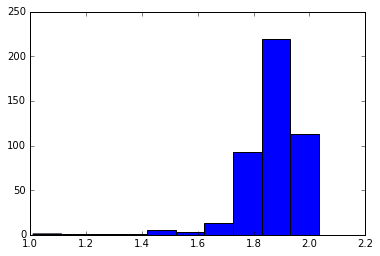

In [7]:
# Input stuff
nsteps = 500 #MC steps to run
maxchange = 0.5 #Maximum allowed parameter change
Nmols = 3 #Number of molecules to examine
equilsteps = 50 #Discard data up to this step number from plots/stats

# FURTHER INPUT: Define prior for this parameter
def prior(theta):
    """Uniform prior for this parameter"""
    if theta < 1.0:
        return 0
    elif theta > 2.2:
        return 0
    else: return 1

# Make sure I use Nmols molecules for which this parameter changes the energy - it might not occur in all molecules
molidx_list = []
ct=0
while len(molidx_list) < Nmols:
    if param_is_in_mol[ct]:
        molidx_list.append(ct)
        ct+=1
    else:
        ct+=1
    
# Extract which parameters occur in which molecules so we can make sure to score based on molecules using the 
# parameters we're changing
from smarty.forcefield_utils import get_molecule_parameterIDs
parameters_by_molecule, parameters_by_ID = get_molecule_parameterIDs( oemols, ffxml)

# Init storage for energies and parameter values
energies = np.zeros((nsteps, Nmols), np.float32)
param_vals = np.zeros((nsteps), np.float32)


# Init storage for calculated values
calcE = np.zeros( (Nmols), np.float32)
oldE = np.zeros( (Nmols), np.float32)
# Retrieve measured and uncertainties
measE = [ ref_energies[idx] for idx in molidx_list ]
meas_s_E = np.array([mean_unc]*Nmols)


# Do MC parameter sampling; for each parameter sample evaluate energies for all target molecules
paramval = float(dummyval) #Starting parameter value
moveff=copy.deepcopy(ff)
params = moveff.getParameter(smirks=smirks)
params[param_key]=str(paramval)
moveff.setParameter(params, smirks=smirks)


# Evaluate likelihood for our starting point
for idx in molidx_list:
    # Pull molecule
    mol = oemols[idx]
    # Create system for energy eval
    topology = topologies[idx]
    system=moveff.createSystem(topology, [mol])
    # Get coordinates
    cpositions=reformat_oemol_coordinates(mol)
    # Get energy
    oldE[idx] = get_energy(system, cpositions[:,:,0])

print("Old energies:", oldE)
print("Measured energies:", measE)
print("Uncertainty %.4g" % mean_unc)
    
# Evaluate old likelihood    
oldlog, oldlike = log_likelihood(oldE, measE, meas_s_E)
accepted = 0
print("Old likelihood %.4g (log %.4f)" % (oldlike, oldlog))
# Now that we have likelihood for starting point, do MC of parameter moves
for step in range(nsteps):
    # Propose move
    chg = random.uniform(-maxchange,maxchange)
    newparam = paramval+chg
    
    # Focus only on things for which prior isn't zero
    while prior(newparam)==0:
        chg = random.uniform(-maxchange,maxchange)
        newparam = paramval+chg
    newparam = paramval+chg
    #print("\nProposed parameter value %.4g" % newparam)

    # Prep for energy evaluation
    params[param_key]=str(newparam)
    moveff.setParameter(params, smirks=smirks)

    # Get new energy and likelihood
    for idx in range(Nmols):
        # Pull molecule
        mol = oemols[idx]
        # Create system for energy eval
        topology = topologies[idx]
        system=moveff.createSystem(topology, [mol])
        # Get coordinates
        cpositions = reformat_oemol_coordinates(mol)
        # Get energy
        calcE[idx] = get_energy(system, cpositions[:,:,0])
    #print("New energies:", calcE)
        
    newlog, newlike = log_likelihood(calcE, measE, meas_s_E)
    #print("New likelihood %.4g (log %.4f)" % (newlike, newlog))
    
    # Accept or reject move
    Pacc = newlike*prior(newparam)/(oldlike*prior(paramval))
    if step%50==0:
        # Print some progress info every N steps
        print("Step %s; current parameter value %.3g." % (step, paramval))
        #print("   Current energies: ", calcE)
    if random.random() < Pacc: #Accept
        # Update "old" stuff if we accepted
        oldE = calcE
        oldlog, oldlike = newlog, newlike
        paramval = newparam
        accepted+=1
        
    # Store data regardless
    energies[step][:] = oldE
    param_vals[step] = paramval

print("Acceptance ratio %.2f" % (float(accepted)/float(nsteps)))
hist = pl.hist(param_vals[equilsteps:])
print("Mean parameter value %.3g (std %.3g)" % ( param_vals[equilsteps:].mean(), param_vals[equilsteps:].std()))
# Original parameter value?
params = ff.getParameter(smirks=smirks)
print("Original parameter value %.3g" % float(params[param_key]))


## Now extend our parameter sampling to multiple parameters

Now we're jumping off of the example immediately above, which focused on using several molecules to constrain a single parameter. Presumably the additional molecules do not provide much value, since it's only a single parameter.

Here, we will begin modifying a second parameter at the same time. Now, additional molecules will presumably constrain the parameter more tightly. Initially we will focus on the radius and well-depth for the same molecule.

Major changes needed relative to above:
* Change not just one parameter key but two
  * Requires generalizing prior
  * Generalize choice of starting parameter value (pick a random point within prior?)
  * Requires making lists/arrays of other things to manipulate
* Each cycle pick a random parameter key and propose changing it
* Have to track not just one array of parameters for final analysis but two (stored in dictionary keyed by parameter key)
* Will need a lot more iterations because of coupling
* Will want to visualize coupling via some sort of heat map
* Will want to look at how addition of extra molecules further constrains parameters

### First set up by picking what parameter(s) to modify and making sure we look at molecules containing these

In [68]:
# Start by setting what parameter(s) to modify

# What parameter(s) are we going to modify?
# List of smirks corresponding to lines to work on
smirkslist = ['[#6X4:1]-[#6X4:2]'] #Carbon bonded parameter 
# What keys to modify for each smirks
modify_key_by_smirks = {'[#6X4:1]':['rmin_half', 'epsilon']}
modify_key_by_smirks = {'[#6X4:1]-[#6X4:2]':['length', 'k']} 

# USAGE NOTE: Due to exclusions and size of molecules, for vdW parameter sampling, many molecular energies are
# just not that sensitive to particular parameters - i.e. for the first molecule, the energy is almost insensitive
# to the [#6X4:1] vdW parameters, as well as for many other molecules. Presumably this will be less the case for
# protons and for hydrogen bond acceptors, but for buried atoms it will likely often be the case.
                        
                        
# Figure out how to determine which molecules use the SMIRKS we're interested in
from smarty.forcefield_labeler import *
ffxml = get_data_filename('forcefield/Frosst_AlkEtOH.ffxml')
lb = ForceField_labeler(ffxml)
labels = lb.labelMolecules(oemols)

def param_in_mols(labels, smirks):
    """Return list of True/False values as to whether specified SMIRKS patterns are in the molecules
    for which labels are provided"""
    smirks_in_mol = []
    for mol_entry in range(len(labels)):
        found = False
        for force in labels[mol_entry].keys():
            for (atom_indices, pid, s) in labels[mol_entry][force]:
                if s==smirks and not found:
                    smirks_in_mol.append(True)
                    found = True
        if not found:
            smirks_in_mol.append(False)
    return smirks_in_mol

# Make a list of True/False for which molecules contain at least one of the SMIRKS we're working on
param_is_in_mol = []
for smirks in smirkslist:
    if len(param_is_in_mol)==0:
        param_is_in_mol = param_in_mols(labels, smirks)
    else:
        tmp = param_in_mols(labels, smirks)
        for idx in range(len(tmp)):
            if tmp[idx]:
                param_is_in_mol[idx] = True
                
#print(param_is_in_mol)


### Do prep for our actual parameter sampling

In [160]:
# INPUT STUFF:
# Basic controls
nsteps = 1000 #MC steps to run
Nmols = 1 #Number of molecules to examine
equilsteps = 50 #Discard data up to this step number from plots/stats

# Define parameter range to consider and move range
# Note currently we only have a single k which is used for bonds and angles
prange = {'rmin_half':[1.0, 2.2], 'epsilon':[0.0, 0.3], 'length':[1.4,1.6], 'k':[10.,1000.]}
move_range = {'rmin_half':0.5, 'epsilon':0.2, 'length':0.05, 'k':1.}

# FURTHER INPUT: Define prior for this parameter
def prior(theta, prange, parameter_key):
    """Defines a uniform prior
    
    Parameters
    ----------
    theta : float
        Parameter value to consider
    prange : dict
        Dictionary, keyed by parameter type, defining the parameter range to consider.
    parameter_key : str
        key from the dictionary which applies to this parameter
    """
    bounds = prange[parameter_key]
    if theta < bounds[0]: 
        return 0
    elif theta > bounds[1]:
        return 0
    else: return 1
    
        

# Make sure I use Nmols molecules for which this parameter changes the energy - it might not occur in all molecules
molidx_list = []
ct=0
while len(molidx_list) < Nmols:
    if param_is_in_mol[ct]:
        molidx_list.append(ct)
        ct+=1
    else:
        ct+=1
    

# Init storage for energies and parameter values; also pick starting parameter values
energies = np.zeros((nsteps, Nmols), np.float32)
log_likelihood_t = np.zeros((nsteps), np.float32)
param_vals = {}
start_param_vals = {}
for smirks in smirkslist:
    param_vals[smirks] = {}
    start_param_vals[smirks] = {}
    for param_key in modify_key_by_smirks[smirks]:
        # Array for storing full set of parameter values
        param_vals[smirks][param_key] = np.zeros((nsteps), np.float32)
        # Pick and store initial parameter values
        this_range = prange[param_key]
        # TEMPORARY DEBUG: START IN THE RIGHT PLACE
        start_param_vals[smirks][param_key] = ff.getParameter(smirks=smirks)[param_key]
        #start_param_vals[smirks][param_key] = random.uniform(this_range[0], this_range[1])

# Init storage for calculated values
calcE = np.zeros( (Nmols), np.float32)
oldE = np.zeros( (Nmols), np.float32)
# Retrieve measured and uncertainties
measE = [ ref_energies[idx] for idx in molidx_list ]
meas_s_E = np.array([mean_unc]*Nmols)


# Set starting parameter values and initialize force field
moveff=copy.deepcopy(ff)
for smirks in smirkslist:
    params = moveff.getParameter(smirks=smirks)
    for param_key in modify_key_by_smirks[smirks]:
        params[param_key]=str(start_param_vals[smirks][param_key])
    moveff.setParameter(params, smirks=smirks)

# Evaluate likelihood for our starting point
print("Evaluating initial likelihood...")
for (idx, molid) in enumerate(molidx_list):
    print("   Smiles string for this molecule %s" % OECreateIsoSmiString(oemols[idx]))
    # Pull molecule
    mol = oemols[molid]
    # Create system for energy eval
    topology = topologies[molid]
    system=moveff.createSystem(topology, [mol])
    # Get coordinates
    cpositions=reformat_oemol_coordinates(mol)
    # Get energy
    oldE[idx] = get_energy(system, cpositions[:,:,0])

print("Measured energies:", measE)
print("Starting parameter values:", start_param_vals)
print("Starting energies:", oldE)
print("Uncertainty %.4g" % mean_unc)
    
# Evaluate old likelihood    
oldlog, oldlike = log_likelihood(oldE, measE, meas_s_E)
accepted = 0
print("Old likelihood %.4g (log %.4f)" % (oldlike, oldlog))



Evaluating initial likelihood...
   Smiles string for this molecule C
('Measured energies:', [30.975018688180398])
('Starting parameter values:', {'[#6X4:1]-[#6X4:2]': {'length': '1.526', 'k': '620.0'}})
('Starting energies:', array([ 30.97501945], dtype=float32))
Uncertainty 0.3983
Old likelihood 0.6321 (log -0.4586)


### Now actually run MC on our parameters

Sample using the parameters chosen/number of steps from above and collect statistics. Analysis/visualization of results will be done in a separate cell.

In [161]:
# Now that we have likelihood for starting point, do MC of parameter moves
accepted_by_pkey={}
oldlog = -1e20 # dummy value to kick things off
for step in range(nsteps):
    # Pick a random smirks to change
    smirks = random.choice(smirkslist)
    # Pick a random parameter key to change
    param_key = random.choice(modify_key_by_smirks[smirks])
    if not param_key in accepted_by_pkey:
        accepted_by_pkey[param_key]=0
    
    # Propose move
    chg = random.uniform(-move_range[param_key],move_range[param_key])
    # Get parameter value
    params = moveff.getParameter(smirks=smirks)
    paramval = float(params[param_key])
    newparam = paramval + chg
    
    # Focus only on things for which prior isn't zero
    while prior(newparam, prange, param_key)==0:
        chg = random.uniform(-move_range[param_key],move_range[param_key])
        newparam = paramval+chg
    newparam = paramval+chg
    
    # Prep for energy evaluation
    params[param_key]=str(newparam)
    moveff.setParameter(params, smirks=smirks)

    # Get new energy and likelihood
    for (idx, molid) in enumerate(molidx_list):
        # Pull molecule
        mol = oemols[molid]
        # Create system for energy eval
        topology = topologies[molid]
        system=moveff.createSystem(topology, [mol])
        # Get coordinates
        cpositions = reformat_oemol_coordinates(mol)
        # Get energy
        calcE[idx] = get_energy(system, cpositions[:,:,0])
        
    #print("New energies:", calcE)
        
    newlog, newlike = log_likelihood(calcE, measE, meas_s_E)
    #print("   New likelihood %.4g (log %.4f)" % (newlike, newlog))
    
    # Accept or reject move
    Pacc = newlike*prior(newparam, prange, param_key)/(oldlike*prior(paramval, prange, param_key))
    if step%50==0:
        # Print some progress info every N steps
        print("Step %s; current parameter value %.3g for %s %s." % (step, paramval, smirks, param_key))
        #print("   Current energies: ", calcE)
    if random.random() < Pacc: #Accept
        #print "   Accepted"
        # Update "old" stuff if we accepted
        oldE = calcE
        oldlog, oldlike = newlog, newlike
        paramval = newparam
        accepted_by_pkey[param_key]+=1
        #print("   Accepting proposed parameter value %.4g for %s parameter %s" % (newparam, smirks, param_key))
    else:
    #    print("   Rejecting proposed parameter value %.4g for %s parameter %s" % (newparam, smirks, param_key))
        pass
        
        
    # Store data regardless
    energies[step][:] = oldE
    param_vals[smirks][param_key][step] = paramval
    log_likelihood_t[step]=oldlog
    # Store values for any other parameters of this SMIRKS we're not changing
    for pkey in modify_key_by_smirks[smirks]:
        if pkey != param_key:
            param_vals[smirks][pkey][step] = param_vals[smirks][pkey][step-1]
    # Store values for any parameters of other SMIRKS we're not changing
    for other_smirks in smirkslist:
        if other_smirks != smirks:
            for pkey in modify_key_by_smirks[smirks]:
                param_vals[other_smirks][pkey][step] = param_vals[other_smirks][pkey][step-1]

for pkey in accepted_by_pkey:
    print("Acceptance ratio for %s is %.2f" % (pkey, float(accepted_by_pkey[pkey])/float(nsteps)))


Step 0; current parameter value 1.53 for [#6X4:1]-[#6X4:2] length.
Step 50; current parameter value 620 for [#6X4:1]-[#6X4:2] k.
Step 100; current parameter value 1.42 for [#6X4:1]-[#6X4:2] length.
Step 150; current parameter value 1.51 for [#6X4:1]-[#6X4:2] length.
Step 200; current parameter value 1.51 for [#6X4:1]-[#6X4:2] length.
Step 250; current parameter value 618 for [#6X4:1]-[#6X4:2] k.
Step 300; current parameter value 1.44 for [#6X4:1]-[#6X4:2] length.
Step 350; current parameter value 619 for [#6X4:1]-[#6X4:2] k.
Step 400; current parameter value 1.47 for [#6X4:1]-[#6X4:2] length.
Step 450; current parameter value 629 for [#6X4:1]-[#6X4:2] k.
Step 500; current parameter value 630 for [#6X4:1]-[#6X4:2] k.
Step 550; current parameter value 1.5 for [#6X4:1]-[#6X4:2] length.
Step 600; current parameter value 627 for [#6X4:1]-[#6X4:2] k.
Step 650; current parameter value 1.45 for [#6X4:1]-[#6X4:2] length.
Step 700; current parameter value 1.48 for [#6X4:1]-[#6X4:2] length.
Step 

### Do analysis/visualization of the results from above

This is a first pass at visualization of the above. 

Smirks [#6X4:1]-[#6X4:2]:
   Mean length value 1.5 (std 0.0465)
   Force field parameter value 1.53
   Mean k value 545 (std 31.8)
   Force field parameter value 620
Most likely parameter values:
[773]
   [#6X4:1]-[#6X4:2]:  length = 1.521, k = 535.904, log likelihood -0.4586
('Energies at step 773:', array([ 30.97506332], dtype=float32))
('Reference energies:', [30.975018688180398])


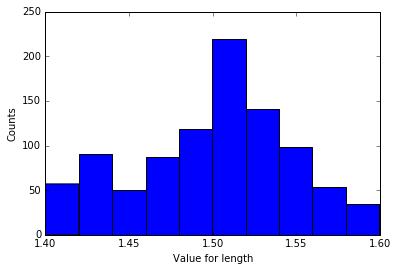

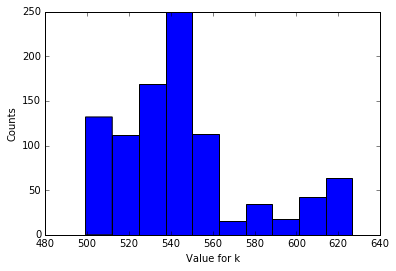

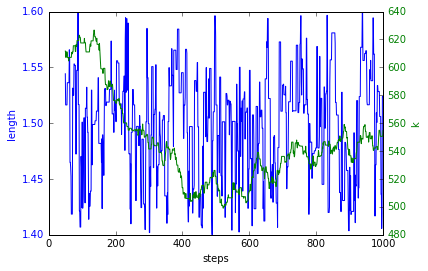

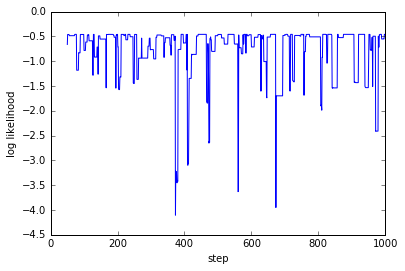

In [158]:
# Do stats/graphics for parameter sampling from above
# Do first smirks pattern only
smirks = smirkslist[0]

# Plot histogram for each parameter under that smirks
print("Smirks %s:" % smirks)
for pkey in modify_key_by_smirks[smirks]:
    hist = pl.hist(param_vals[smirks][pkey][equilsteps:])
    pl.xlabel('Value for %s' % pkey)
    pl.ylabel('Counts')
    print("   Mean %s value %.3g (std %.3g)" % (pkey, param_vals[smirks][pkey][equilsteps:].mean(), param_vals[smirks][pkey][equilsteps:].std()))
    print("   Force field parameter value %.3g" % float(ff.getParameter(smirks)[pkey]))
    pl.figure()

# Plot parameter values on same plot with dual y axes
fig, ax1 = pl.subplots()
ax1.plot( np.arange(equilsteps,nsteps), param_vals[smirks][modify_key_by_smirks[smirks][0]][equilsteps:], 'b-')
ax1.set_xlabel('steps')
ax1.set_ylabel(modify_key_by_smirks[smirks][0], color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax2 = ax1.twinx()
ax2.plot( np.arange(equilsteps,nsteps), param_vals[smirks][modify_key_by_smirks[smirks][1]][equilsteps:], 'g-')
ax2.set_ylabel(modify_key_by_smirks[smirks][1], color='g')
for tl in ax2.get_yticklabels():
    tl.set_color('g')
pl.figure()

# Plot likelihood vs step
pl.plot( np.arange(equilsteps, nsteps), log_likelihood_t[equilsteps:])
pl.xlabel('step')
pl.ylabel('log likelihood')

# Print most likely parameter set found
mostlikelyval = log_likelihood_t.max()
idx = np.where(log_likelihood_t==mostlikelyval)
print("Most likely parameter values:")
for smirks in smirkslist:
    line="   " + smirks + ":  "
    for st in idx[0]:
        for pkey in modify_key_by_smirks[smirks]:
            line += "%s = %.3f, " % (pkey, param_vals[smirks][pkey][st])
        line+= "log likelihood %.4g" % log_likelihood_t[st]
        print(line)
for st in idx[0]:
    print("Energies at step %s:" % st, energies[st])
print("Reference energies:", measE)

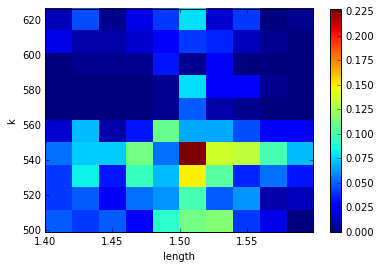

In [159]:
# Do a 2D heatmap for each 2D parameter
from matplotlib.colors import LogNorm

# Normalize data and reformat, then do plots
probs_by_smirks={}
#nbins = 30
for smirks in smirkslist:
    # Check if 2D parameter sampling; if so, grab data and do plots
    if len(modify_key_by_smirks[smirks])==2: 
        # Init storage
        #probs_by_smirks[smirks] = np.zeros((nbins,nbins), np.float32)
        # Pull data range 
        pkeys = modify_key_by_smirks[smirks]
        #xrange = prange[pkeys[0]]
        #yrange = prange[pkeys[1]]
        
        # Pull x and y values
        xvals = param_vals[smirks][pkeys[0]][equilsteps:]
        yvals = param_vals[smirks][pkeys[1]][equilsteps:]
        
        # Plot
        pl.figure()
        #pl.hist2d(xvals, yvals, normed=True, norm=LogNorm())
        pl.hist2d(xvals, yvals, normed=True)
        pl.colorbar()
        pl.xlabel(pkeys[0])
        pl.ylabel(pkeys[1])

## Major to-dos:
* Figure out step size to use for each parameter value for best mixing
* Look at how adding additional molecules constrains the parameters more and impacts the likelihood. NOTE: It's possible that adding additional molecules will NOT further constrain bond parameters if conformers are generated from Omega, as bond lengths may not vary across conformers.
* Look at doing more than two parameters (one SMIRKS) at once
* See to-do items in other notebook
